# Language-Visual Saliency With CLIP and OpenVINO™

The notebook will cover the following:
* What is a _saliency map_ and how it can be used
* What is CLIP neural network and how can it be used to create saliency maps
* How to split a neural network into parts to infer it separately
* How to speed up inference with OpenVINO™ and asynchronous execution

## Saliency Maps

Saliency map - a visualization technique that highlights regions of interest in a picture. It might be used, for example, to [explain image classification predictions](https://academic.oup.com/mnras/article/511/4/5032/6529251#389668570) with respect to a particular label. Here is a saliency map for a galaxy image classifier:

![](https://oup.silverchair-cdn.com/oup/backfile/Content_public/Journal/mnras/511/4/10.1093_mnras_stac368/3/m_stac368fig1.jpeg?Expires=1677785927&Signature=cAyId2u3u4OTNjPbJbK2DsxUfOUjVavSXbhWy1uZT96E-~gBI8ccSUWpelXZ47XRpw8Ce7jPF1obNUU4jcQtpsINSQimXHu7FUj~fFUBOqt8yeXYupzgVDPys6LfEU-j8u2X1oejwIco~t~PrC65ac3cs40LbUyQVdXZK5RD-I5Hq2~KbTsKRC4pDDzcq5kMWqvTuZ0ux9Qb4FiltdForE4LQbD6CWKl53SmMZ8HHfNrwQDMgXKLEDRfwCYx9qL15jxlxKYGusMuDfdjNbkNf~ex7DKmAsV5JphlDAu6SgBC0SSZ9REZlMXCDqlSKET4RX6fhNWFfbHF3iW3vlYLYQ__&Key-Pair-Id=APKAIE5G5CRDK6RD3PGA)

*[image source](https://academic.oup.com/mnras/article/511/4/5032/6529251#389668570)

## CLIP

### What Is CLIP?

CLIP (Contrastive Language–Image Pre-training) - is a neural network that can work with images and texts. It was trained to predict which randomly sampled text snippets are close to the given image, meaning that a text better describes the image. Here is a visualisation of the pretraining:

![](https://openaiassets.blob.core.windows.net/$web/clip/draft/20210104b/overview-a.svg)
[image_source](https://openai.com/blog/clip/)

To solve the task CLIP uses two parts - `Image Encoder` and `Text Encoder`. Both parts are used to produce embeddings - vectors of floating point numbers - images and texts respectively. Given two vectors one can define and measure the similarity between them. `cosine_similarity` is a popular vector similarity measure to do that. It is defined as a dot product of two vectors divided by the product of their norms:

$$
\text{cosine_similarity}(v_1, v_2) = \frac{v_1 \cdot v_2}{|v_1||v_2|}
$$

The result can be between $-1$ and $1$, where $1$ means that the vectors are similar, $0$ means that the vectors are not "connected" at all and $-1$ is for vectors with somehow opposite "meaning". That is what OpenAI used to train CLIP - they sample a bunch of texts and images and organize them so the first text corresponds to the first image in the batch, the second text to the second image and so on. then they measured cosine similarities between all text and all images and put the result into a matrix. If the matrix has numbers close to $1$ on a diagonal and close to $0$ everywhere else, then the network is appropriately trained.

### How To Build a Saliency Map With CLIP?

So, we can give a picture and a text for the CLIP, which gives back two vectors, we calculate a cosine similarity between these vectors and get a number between $-1$ and $1$ that tells us if the text describes the picture or not.
The idea is that _some regions of the picture is closer to the text query_ than other, so we can exploit that difference to build the saliency map. Here is how it can be done:

1. Compute `query` and `picture` similarity - this will represent the _neutral value_ $s_0$ on the `saliency map`
2. Get a random `crop` of the picture
3. Compute `crop` and `query` similarity 
4. Subtract the $s_0$ from it - if the value is positive, the `crop` is closer to the `query` and it should be a red region on the saliency map or the blue otherwise
5. Update the corresponding region on the `saliency map` 
6. Repeat items 2-5 many times (`n_iters`)

## Initial implementation

In [1]:
from pathlib import Path
from typing import Tuple, Union

from matplotlib import colors
import matplotlib.pyplot as plt
import numpy as np
import requests
import torch
import tqdm
from PIL import Image
from transformers import CLIPModel, CLIPProcessor

2023-02-08 18:36:03.787620: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-02-08 18:36:03.790958: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-08 18:36:03.790969: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


To get the CLIP model we will use the `transformers` library and an official `openai/clip-vit-base-patch16` from OpenAI. You could use any CLIP model from Huggingface Hub, just replace a model checkpoint in the cell below.

There are several preprocessing steps required to get text and image data to the model. Images have to be resized, cropped and normalized, and the text has to be split into tokens and swapped by token ids. To do that we will use `CLIPProcessor`, which encapsulates all of the preprocessing steps.

In [2]:
model_checkpoint = "openai/clip-vit-base-patch16"

model = CLIPModel.from_pretrained(model_checkpoint).eval()
processor = CLIPProcessor.from_pretrained(model_checkpoint)

Let's write helper functions first. We will generate crop coordinates and size with `get_random_crop_params`, and get an actual crop with `get_crop_image`. To update the saliency map with calculated similarity, we will use `update_saliency_map`. A `cosine_similarity` function is just a code representation of the formula above.

In [3]:
def get_random_crop_params(
    image_height: int, image_width: int, min_crop_size: int
) -> Tuple[int, int, int, int]:
    crop_size = np.random.randint(min_crop_size, image_height)

    x = np.random.randint(image_width - crop_size + 1)
    y = np.random.randint(image_height - crop_size + 1)
    return x, y, crop_size


def get_cropped_image(
    im_tensor: np.array, x: int, y: int, crop_size: int
) -> np.array:
    return im_tensor[
        y : y + crop_size,
        x : x + crop_size,
        ...
    ]


def update_saliency_map(
    saliency_map: np.array, similarity: float, x: int, y: int, crop_size: int
) -> None:
    saliency_map[
        y : y + crop_size,
        x : x + crop_size,
    ] += similarity


def cosine_similarity(
    one: Union[np.ndarray, torch.Tensor], other: Union[np.ndarray, torch.Tensor]
) -> Union[np.ndarray, torch.Tensor]:
    return one @ other.T / (np.linalg.norm(one) * np.linalg.norm(other))

Parameters that are left to define:
- `n_iters` - how many times the procedure
- `min_crop_size` - minimum size of the crop window
- `query` - text that will be used to query the image
- `image` - the actual image that will be queried, we will download the image from the link

In [4]:
n_iters = 2000
min_crop_size = 50

query = "cat"
picture_url = "https://week.ba/wp-content/uploads/2019/12/porodica-djeca.jpg"
image = Image.open(requests.get(picture_url, stream=True).raw)
im_tensor = np.array(image)

x_dim, y_dim = image.size

Given the `model` and `processor` the actual inference is simple - transform text and image into combined `inputs` and pass it to the model:

In [5]:
inputs = processor(text=[query], images=[im_tensor], return_tensors="pt")
with torch.no_grad():
    results = model(**inputs)
results.keys()

odict_keys(['logits_per_image', 'logits_per_text', 'text_embeds', 'image_embeds', 'text_model_output', 'vision_model_output'])

The model produces several outputs, but for our application, we are interested in `text_embeds` and `image_embeds` which are the vectors for text and image respectively. Now we can calculate `initial_similarity` between the `query` and the `image`. We also initialize a saliency map. Numbers in the comments correspond to items in the "How To Build a Saliency Map With CLIP?" list above.

In [6]:
initial_similarity = cosine_similarity(results.text_embeds, results.image_embeds).item()  # 1
saliency_map = np.zeros((y_dim, x_dim))

for _ in tqdm.notebook.tqdm(range(n_iters)):  # 6
    x, y, crop_size = get_random_crop_params(y_dim, x_dim, min_crop_size)
    im_crop = get_cropped_image(im_tensor, x, y, crop_size)  # 2

    inputs = processor(text=[query], images=[im_crop], return_tensors="pt")
    with torch.no_grad():
        results = model(**inputs)  # 3

    similarity = cosine_similarity(results.text_embeds, results.image_embeds).item() - initial_similarity  # 4
    update_saliency_map(saliency_map, similarity, x, y, crop_size)  # 5

  0%|          | 0/2000 [00:00<?, ?it/s]

To visualise resulting saliency map we can use `matplotlib`. 

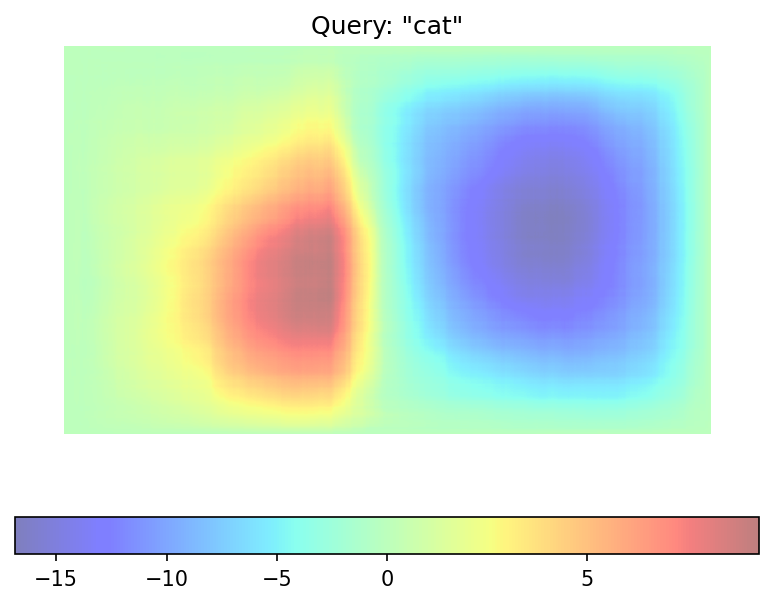

In [8]:
plt.figure(dpi=150)
plt.imshow(saliency_map, norm=colors.TwoSlopeNorm(vcenter=0), cmap='jet', alpha=0.5)
plt.colorbar(location="bottom")
plt.title(f'Query: \"{query}\"')
plt.axis("off")
plt.show()

Let's overlay the saliency map on the picture:

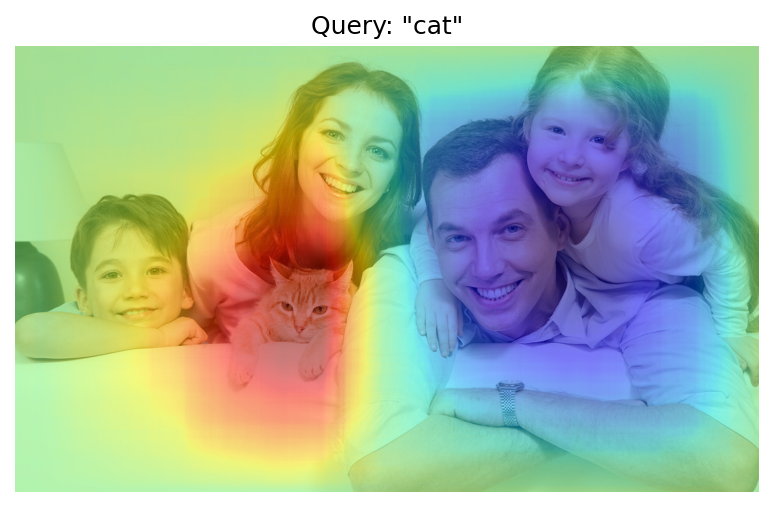

In [9]:
plt.figure(dpi=150)
plt.imshow(im_tensor)
plt.imshow(
    saliency_map, 
    norm=colors.TwoSlopeNorm(vcenter=0), 
    cmap="jet", 
    alpha=0.5,
)
plt.title(f'Query: "{query}"')
plt.axis("off")
plt.show()

## Separate text and visual processing

The code above is working as intended, but there are some repeated computations that can be easily avoided. The text embedding can be computed once, because does not depend on the input image. This separation will also be usefull in the future. The initial preparation will stay the same, because we still need to compute the similarity between text and full image. After that a `get_image_features` method could be used to obtain embeddings for the cropped images.

  0%|          | 0/2000 [00:00<?, ?it/s]

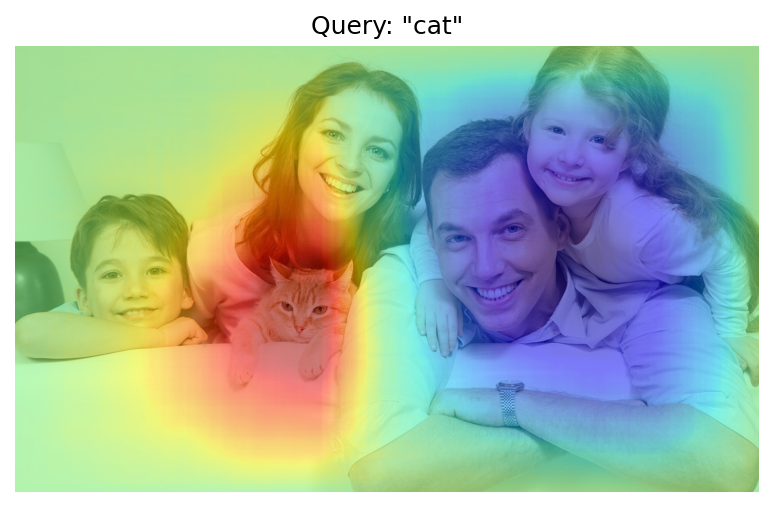

In [10]:
inputs = processor(text=[query], images=[im_tensor], return_tensors="pt")
with torch.no_grad():
    results = model(**inputs)
text_embeds = results.text_embeds  # save text embeddings to use them later

initial_similarity = cosine_similarity(text_embeds, results.image_embeds).item()
saliency_map = np.zeros((y_dim, x_dim))

for _ in tqdm.notebook.tqdm(range(n_iters)):
    x, y, crop_size = get_random_crop_params(y_dim, x_dim, min_crop_size)
    im_crop = get_cropped_image(im_tensor, x, y, crop_size)

    image_inputs = processor(images=[im_crop], return_tensors="pt")  #  crop preprocessing
    with torch.no_grad():
        image_embeds = model.get_image_features(**image_inputs)  # calculate image embeddings only

    similarity = cosine_similarity(text_embeds, image_embeds).item() - initial_similarity
    update_saliency_map(saliency_map, similarity, x, y, crop_size)

    
plt.figure(dpi=150)
plt.imshow(im_tensor)
plt.imshow(
    saliency_map, 
    norm=colors.TwoSlopeNorm(vcenter=0), 
    cmap="jet", 
    alpha=0.5,
)
plt.title(f'Query: "{query}"')
plt.axis("off")
plt.show()

The result might be slightly different because we use random crops to build a saliency map.

## Convert to OpenVINO Intermediate Representation (IR) format

The process of building saliency map is quite time consuming. To speed it up we will use OpenVINO. OpenVINO is an inference framework, meaning that it is build to run pretrained neural networks efficently. One of the ways to use it - convert a model from original framework representation to an OpenVINO Intermediate Representation (IR) format and then load it for inference. Our model is currently uses PyTorch. To get an IR we firsts need to convert PyTorch model into ONNX format. It can be done with `torch.onnx.export` function. See the [PyTorch documentation](https://pytorch.org/docs/stable/onnx.html) for more info on ONNX conversion. 

In [12]:
model_name = model_checkpoint.split('/')[-1]

onnx_model_path = Path("onnx") / f"{model_name}.onnx"
onnx_model_path.parent.mkdir(exist_ok=True)

torch.onnx.export(
    model,  # model being run
    dict(inputs),
    onnx_model_path,  # where to save the model
    opset_version=14,  # the ONNX version to export the model to
    input_names=["input_ids", "pixel_values", "attention_mask"],  # the model's input names
    output_names=["logits_per_image", "logits_per_text", "text_embeds", "image_embeds"],  # the model's output names
    dynamic_axes={  # variable length axes
        "input_ids": {0: "batch", 1: "sequence"},
        "pixel_values": {0: "batch", 1: "num_channels", 2: "height", 3: "width"},
        "attention_mask": {0: "batch", 1: "sequence"},
        "logits_per_image": {0: "batch"},
        "logits_per_text": {0: "batch"},
        "text_embeds": {0: "batch"},
        "image_embeds": {0: "batch"}
    }
)

/home/apaniuko/python/openvino_notebooks/venv/lib/python3.10/site-packages/transformers/models/clip/modeling_clip.py:284: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if attn_weights.size() != (bsz * self.num_heads, tgt_len, src_len):
/home/apaniuko/python/openvino_notebooks/venv/lib/python3.10/site-packages/transformers/models/clip/modeling_clip.py:324: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if attn_output.size() != (bsz * self.num_heads, tgt_len, self.head_dim):
/home/apaniuko/python/openvino_notebooks/venv/lib/python3.10/site-packages/transf

Right now we can load an ONNX file to OpenVINO and serialize the resulting model into IR, but it won't be optimal in our use case. As you already know, CLIP model contains two separate parts - image encoder and text encoder. We could split the CLIP into two models and call them separately. How could we do that?

To convert the model to IR you can use Model Optimizer (MO). When you convert the model to OpenVINO model optimizer allows specifying the inputs and outputs you want to use. During the conversion, it will trim the remaining parts of the model. So if we pass the text inputs and outputs, the MO will "extract" the text part of the model only.

The outputs we are interested in are already known - `text_embeds` and `image_embeds`. The inputs for image is `pixel_values`, and the remaining `input_ids` and `attention_mask` are correspond to text. We are also make the image input of the model static, because there are no variation in the input size after preprocessing.

In [13]:
from openvino.runtime import serialize
from openvino.tools import mo


text_ov_model = mo.convert_model(
    onnx_model_path, 
    compress_to_fp16=True,
    input="input_ids,attention_mask",
    output="text_embeds",
)

input_h_w = ",".join(map(str, processor.image_processor.crop_size.values()))
image_ov_model = mo.convert_model(
    onnx_model_path, 
    compress_to_fp16=True,
    input=f"pixel_values",
    input_shape=f"[1,3,{input_h_w}]",
    output="image_embeds",
)

ov_dir = Path("ir")
ov_dir.mkdir(exist_ok=True)
text_model_path = ov_dir / f"{model_name}_text.xml"
image_model_path = ov_dir / f"{model_name}_image.xml"

# write resulting models on disk
serialize(text_ov_model, str(text_model_path))
serialize(image_ov_model, str(image_model_path))

## Inference with OV

In [14]:
from openvino.runtime import Core


core = Core()

text_model = core.read_model(text_model_path)
image_model = core.read_model(image_model_path)

text_model = core.compile_model(model=text_model, device_name="CPU")
image_model = core.compile_model(model=image_model, device_name="CPU")

  0%|          | 0/2000 [00:00<?, ?it/s]

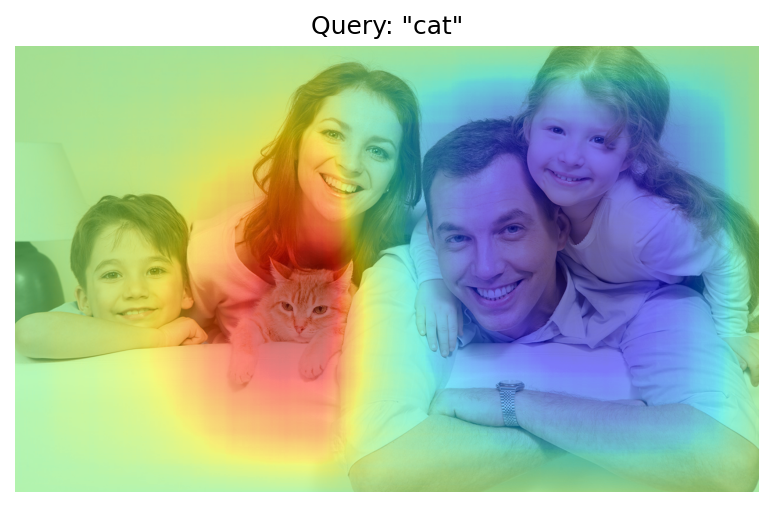

In [16]:
text_inputs = dict(
    processor(text=[query], images=[im_tensor], return_tensors="np")
)
image_inputs = text_inputs.pop("pixel_values")

text_embeds = text_model(text_inputs)[text_model.output()]
image_embeds = image_model(image_inputs)[image_model.output()]

initial_similarity = cosine_similarity(text_embeds, image_embeds)
saliency_map = np.zeros((y_dim, x_dim))

for _ in tqdm.notebook.tqdm(range(n_iters)):
    x, y, crop_size = get_random_crop_params(y_dim, x_dim, min_crop_size)
    im_crop = get_cropped_image(im_tensor, x, y, crop_size)

    image_inputs = processor(images=[im_crop], return_tensors="np").pixel_values
    image_embeds = image_model(image_inputs)[image_model.output()]

    similarity = cosine_similarity(text_embeds, image_embeds) - initial_similarity
    update_saliency_map(saliency_map, similarity, x, y, crop_size)

plt.figure(dpi=150)
plt.imshow(im_tensor)
plt.imshow(
    saliency_map, 
    norm=colors.TwoSlopeNorm(vcenter=0), 
    cmap="jet", 
    alpha=0.5,
)
plt.title(f'Query: "{query}"')
plt.axis("off")
plt.show()

## Async inference

In [28]:
from openvino.runtime import AsyncInferQueue, InferRequest
from time import time


def completion_callback(
    infer_request: InferRequest, 
    user_data,
) -> None:
    pbar = user_data.pop("pbar")
    # image_embeds = next(iter(infer_request.results.values()))
    image_embeds = infer_request.get_output_tensor().data
    
    similarity = (
        cosine_similarity(user_data.pop("text_embeds"), image_embeds) - user_data.pop("initial_similarity")
    )
    update_saliency_map(**user_data, similarity=similarity)
    pbar.update(1)

In [29]:
text_inputs = dict(
    processor(text=[query], images=[im_tensor], return_tensors="np")
)
image_inputs = text_inputs.pop("pixel_values")

text_embeds = text_model(text_inputs)[text_model.output()]
image_embeds = image_model(image_inputs)[image_model.output()]

initial_similarity = cosine_similarity(text_embeds, image_embeds)
saliency_map = np.zeros((y_dim, x_dim))

In [30]:
infer_queue = AsyncInferQueue(image_model)
infer_queue.set_callback(completion_callback)

  0%|          | 0/2000 [00:00<?, ?it/s]

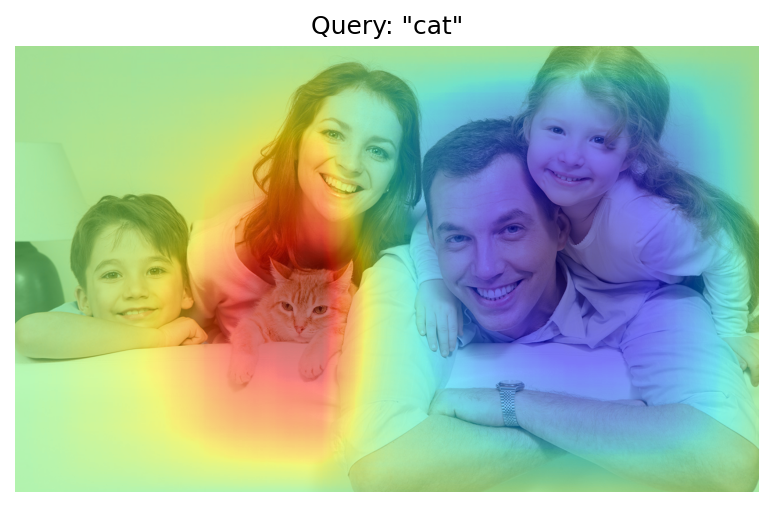

In [32]:
with tqdm.notebook.tqdm(total=n_iters) as pbar:
    for _ in range(n_iters):    
        x, y, crop_size = get_random_crop_params(y_dim, x_dim, min_crop_size)
        im_crop = get_cropped_image(im_tensor, x, y, crop_size)

        image_inputs = processor(images=[im_crop], return_tensors="np", padding=True)
        infer_queue.start_async(
            image_inputs.pixel_values,
            {
                "text_embeds": text_embeds, 
                "saliency_map": saliency_map,
                "initial_similarity": initial_similarity,
                "x": x, 
                "y": y, 
                "crop_size": crop_size,
                "pbar": pbar,
            }
        )

    infer_queue.wait_all()

plt.figure(dpi=150)
plt.imshow(im_tensor)
plt.imshow(
    saliency_map, 
    norm=colors.TwoSlopeNorm(vcenter=0), 
    cmap="jet", 
    alpha=0.5,
)
plt.title(f'Query: "{query}"')
plt.axis("off")
plt.show()

## Pack the Pipeline into a Function

In [34]:
import ipywidgets as widgets


def build_saliency_map(image: Image, query: str, n_iter: int = 2000, min_crop_size=50):
    x_dim, y_dim = image.size
    
    text_inputs = dict(
        processor(text=[query], images=[im_tensor], return_tensors="np")
    )
    image_inputs = text_inputs.pop("pixel_values")

    text_embeds = text_model(text_inputs)[text_model.output()]
    image_embeds = image_model(image_inputs)[image_model.output()]

    initial_similarity = cosine_similarity(text_embeds, image_embeds)
    saliency_map = np.zeros((y_dim, x_dim))

    with tqdm.notebook.tqdm(total=n_iters) as pbar:
        for _ in range(n_iters):    
            x, y, crop_size = get_random_crop_params(y_dim, x_dim, min_crop_size)
            im_crop = get_cropped_image(im_tensor, x, y, crop_size)

            image_inputs = processor(images=[im_crop], return_tensors="np", padding=True)
            infer_queue.start_async(
                image_inputs.pixel_values,
                {
                    "text_embeds": text_embeds, 
                    "saliency_map": saliency_map,
                    "initial_similarity": initial_similarity,
                    "x": x, 
                    "y": y, 
                    "crop_size": crop_size,
                    "pbar": pbar,
                }
            )

        infer_queue.wait_all()

    im_tensor = np.array(image)
    plt.figure(dpi=150)
    plt.imshow(im_tensor)
    plt.imshow(saliency_map.T, cmap='jet', alpha=0.5)
    plt.title(f'Query: \"{query}\"')
    plt.axis("off")
    plt.show()

### Pass An Image by Link 

In [35]:
@widgets.interact_manual(image_link="", query="", n_iter=2000, min_crop_size=50)
def build_saliency_map_from_image_link(
    image_link: str,
    query: str,
    n_iter: int = 2000,
    min_crop_size: int = 50,
) -> None:
    try:
        image_bytes = requests.get(image_link, stream=True).raw
    except requests.RequestException as e:
        print(f"Cannot load image from link: {image_link}\nException: {e}")
        return
    
    image = Image.open(image_bytes)
    build_saliency_map(image, query, n_iter, min_crop_size)

/tmp/ipykernel_749603/251913924.py:2: DeprecationWarning: on_submit is deprecated. Instead, set the .continuous_update attribute to False and observe the value changing with: mywidget.observe(callback, 'value').
  def build_saliency_map_from_image_link(


interactive(children=(Text(value='', description='image_link'), Text(value='', description='query'), IntSlider…

### Pass an Image from Disc 

In [64]:
import io


load_file_widget = widgets.FileUpload(multiple=False)

@widgets.interact_manual(file=load_file_widget, query="Cat", n_iter=2000, window=100)
def build_saliency_map_from_file(
    file: Path,
    query: str = "Cat",
    n_iter: int = 2000,
    window: int = 100,
) -> None:
    image_bytes = io.BytesIO(file[0]["content"])
    try:
        image = Image.open(image_bytes)
    except Exception as e:
        print(f"Cannot load the image: {e}")
        return
    
    build_saliency_map(image, query, n_iter, window)

/tmp/ipykernel_1384414/1982046365.py:7: DeprecationWarning: on_submit is deprecated. Instead, set the .continuous_update attribute to False and observe the value changing with: mywidget.observe(callback, 'value').
  def build_saliency_map_from_file(


interactive(children=(FileUpload(value=(), description='Upload'), Text(value='Cat', description='query'), IntS…